<a href="https://colab.research.google.com/github/hamzaodeh/FYP/blob/main/1_data_cleaning_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!git config --global user.email "odehhamza8@gmail.com"
!git config --global user.name "hamzaodeh"

!rm -rf FYP
!git clone https://github.com/hamzaodeh/FYP.git
%cd FYP


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: Unable to read current working directory: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: Unable to read current working directory: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: could not create work tree dir 'FYP': No such file or directory
[Errno 2] No such file or directory: 'FYP'
/content/phishing-email-detection


In [ ]:
# --- Commit 1: Initial load and null cleanup ---

# 1) Setup
import pandas as pd
import numpy as np
import csv, sys

# Increase limit for very long email bodies
csv.field_size_limit(sys.maxsize)

# Pandas display settings
pd.set_option('display.max_columns', None)

# 2) Data Loading (robust)
# Using on_bad_lines='skip' instead of deprecated error_bad_lines
df = pd.read_csv(
    "/content/DLI/TREC-05.csv",  # <-- adjust path to your file
    engine="python",
    on_bad_lines="skip",
    sep=None,  # autodetect delimiter
    encoding="utf-8",
    encoding_errors="replace",  # handle weird characters
    dtype=str  # read all as string first
)

print("Initial Shape:", df.shape)
print(df.isnull().sum())

# 3) Preprocessing - Remove nulls in key columns
# Convert label and urls to numeric (coerce errors to NaN)
if "label" in df.columns:
    df["label"] = pd.to_numeric(df["label"], errors="coerce")
if "urls" in df.columns:
    df["urls"] = pd.to_numeric(df["urls"], errors="coerce")

# Drop rows where body, subject, or label is missing
required_cols = [c for c in ["body", "subject", "label"] if c in df.columns]
df.dropna(subset=required_cols, inplace=True)

# Fill missing urls with 0 and ensure integer type
if "urls" in df.columns:
    df["urls"] = df["urls"].fillna(0)
    df["urls"] = np.maximum(df["urls"].astype(float), 0).astype(int)

# Strip extra whitespace from text fields
for col in ["subject", "body"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()

df.reset_index(drop=True, inplace=True)
print("After cleaning Shape:", df.shape)

Initial Shape: (53875, 7)
sender        13
receiver    2627
date        2376
subject     2472
body        1214
label       1341
urls        1342
dtype: int64
After cleaning Shape: (51264, 7)


In [ ]:
import os

os.makedirs("data", exist_ok=True)
os.makedirs("notebooks", exist_ok=True)

# Save cleaned CSV inside data/
df.to_csv("data/cleaned_data.csv", index=False)

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   data/cleaned_data.csv

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	TREC-05.csv



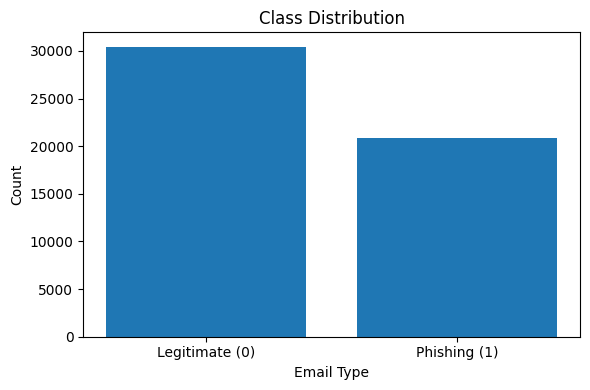

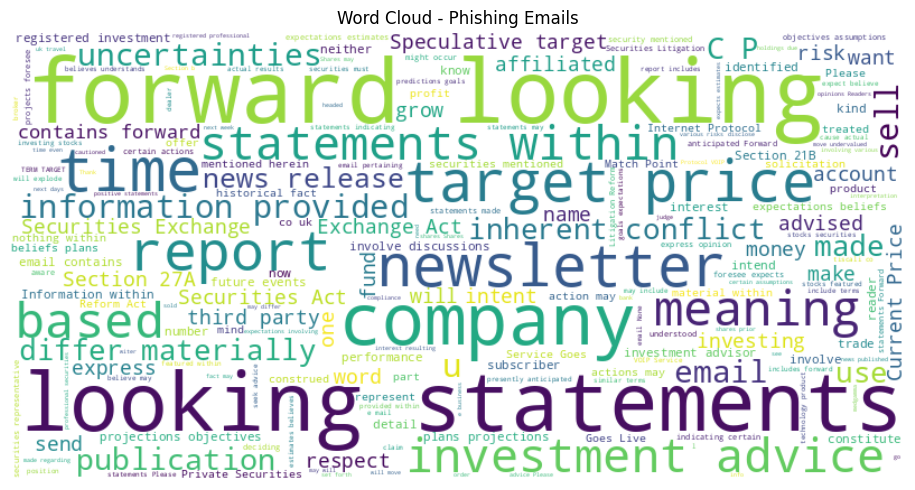

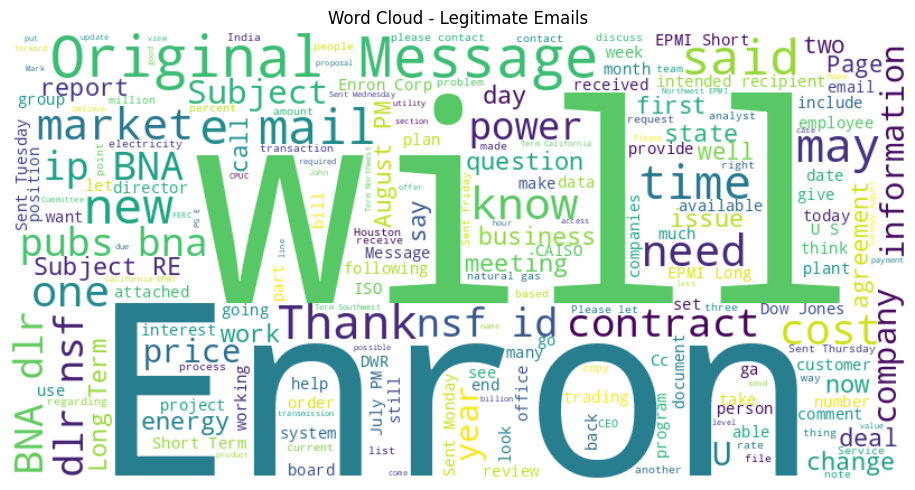

In [ ]:
# --- Commit 2: Class distribution and word cloud ---

import os
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 0) Ensure output folder exists
os.makedirs("results", exist_ok=True)

# 1) Class Distribution
label_counts = df["label"].value_counts().sort_index()  # ensure 0 then 1
plt.figure(figsize=(6, 4))
# Use plain matplotlib to avoid seaborn dependency issues; works fine with your earlier import too.
plt.bar(label_counts.index.astype(int), label_counts.values)
plt.xticks([0, 1], ["Legitimate (0)", "Phishing (1)"])
plt.title("Class Distribution")
plt.xlabel("Email Type")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("results/class_distribution.png")
plt.show()

# 2) Word Clouds (guard against empty/huge text)
def build_text(series, max_chars=1_500_000):
    text = " ".join(series.dropna().astype(str).tolist())
    # Truncate to avoid memory issues with very large corpora
    return text[:max_chars]

phish_text = build_text(df.loc[df["label"] == 1, "body"])
legit_text = build_text(df.loc[df["label"] == 0, "body"])

def safe_wordcloud(text, outfile, title):
    if not text.strip():
        print(f"Skipped {title}: empty text.")
        return
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outfile)
    plt.show()

safe_wordcloud(phish_text, "results/phishing_wordcloud.png", "Word Cloud - Phishing Emails")
safe_wordcloud(legit_text, "results/legit_wordcloud.png", "Word Cloud - Legitimate Emails")

In [ ]:
# --- Commit 3: Saved cleaned dataset for next stage ---

# Save Cleaned Data
df.to_csv("data/cleaned_data.csv", index=False)
print("Cleaned data saved to 'data/cleaned_data.csv'.")

# Summary
print("Final Class Counts:")
print(df['label'].value_counts())
print("Preview:")
print(df[['subject', 'label']].head())

Cleaned data saved to 'data/cleaned_data.csv'.
Final Class Counts:
label
0.0    30434
1.0    20830
Name: count, dtype: int64
Preview:
                                       subject  label
0  FW: June 29 -- BNA, Inc. Daily Labor Report    0.0
1                           NGX failover plan.    0.0
2                            RE: Intranet Site    0.0
3         FW: ENA Upstream Company information    0.0
4                          New Master Physical    0.0
